# Continued EDA for Senior Thesis
Adding Geopatial Bounding

## Dependencies

In [1]:
# libraries that I may potential need:
import pandas as pd
import math
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio
import rasterio.warp
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds
import geopandas as gpd
from shapely.geometry import Point, box
from pandas.plotting import scatter_matrix
import random
import seaborn as sns

## Variables

### Used Google Translate to reencocde variable names:
| original variable name | translated variable name |
| --- |--- |
| gattung_botanisch  | botanical genus     |
| gattung_deutsch    | German genus        |
| art_botanisch      | botanical species   |
| art_deutsch        | German species      |
| alleebaum          | avenue tree         |
| hoehe              | height              |
| stammdurchmesser   | trunk diameter      |
| stammumfang        | trunk circumference |
| kronendurchmesser  | crown diameter      |
| baumpatenschaft    | tree sponsorship    |

In [2]:
# set path to data set
path_tree = '../data/data_gov_de/trees/baeume.json'

# create german to english variable name map
recoded_column_names = {
    'gattung_botanisch' : 'botanical_genus'     ,
    'gattung_deutsch'   : 'German_genus'        ,
    'art_botanisch'     : 'botanical_species'   ,
    'art_deutsch'       : 'German-species'      ,
    'alleebaum'         : 'avenue_tree'         ,
    'hoehe'             : 'height'              ,
    'stammdurchmesser'  : 'trunk_diameter'      ,
    'stammumfang'       : 'trunk_circumference' ,
    'kronendurchmesser' : 'crown_diameter'      ,
    'baumpatenschaft'   : 'tree_sponsorship'    ,
    }

# set standard deviation limit to constrain outliers
sd_limit = 3

# isolate cohorts for analysis that are not outliers and have less than n units min_count = 50
min_count = 50

# Gausian smoother coefficient
smother_sd = 1/2

## Functions

In [3]:
def list_printer(a_list:list, number_of_items_to_print:int = 10000, span:int=80):
    """
    # Formated list printer
    ## Expects: 
     - A list like object
     - number of items from list to print. Default 10000
     - max length of page in. Assumes terminal is using fixed width font. Default 80
    ## Returns: Prints a formated list.
    """
    counter = 1
    list_len = len(a_list)
    max_len = len(max(a_list, key=len)) + 2
    if span > max_len:
        cols = round(span / max_len )
    else: return f'span {span} must be greater than len of longest item in list {max_len} +2'
    for i in a_list:
        if counter > number_of_items_to_print:
            break
        elif counter % cols == 0:
            print(f'{i:^{max_len}}')
        else: 
            print(f'{i:^{max_len}}', end= ' | ')
        counter += 1

def round_to_nearest_n(x, base):
    """
    Rounds a value to the nearest multiple of 'base'.
    """
    return base * round(x / base)

def series_limit(series:pd.Series, sd_limit:int= 1) -> pd.Series:
    """
    # Mask values in a pandas series greater or equal to a limit.
    Limit defined by the number of standard devations away from the series mean the value is.
    Assumes a guasian distribution.
    """
    sample_sd = series.std()
    sample_mean = series.mean()
    limit = sample_mean + (sample_sd*sd_limit)
    mask = series <= limit
    return mask 

## Load Tree Data

In [4]:
# read GeoJson data into a GeoPandas DF
gdf = gpd.read_file(path_tree, encoding='utf-8')

## Clean Tree Data

### translate variable names

In [5]:
# map translated variable names
gdf = gdf.rename(columns=recoded_column_names)

### split variable

In [6]:
# Split common name and species variable and create two new features
# - botanical_species_formal_name
# - botanical_species_common_name
gdf[['botanical_species_formal_name', 'botanical_species_common_name']] = gdf['botanical_species'].str.split(' „', expand=True).fillna(pd.NA)
gdf['botanical_species_common_name'] = gdf['botanical_species_common_name'].str.replace('“', '')

# Create mask for botanical_species_formal_name containing the string 'species'
# - We are isolating units where a generalization from a species to a genus was made.
mask_botanical_species_formal_name = gdf['botanical_species_formal_name'].str.contains('species')
# set masked recs to NA
gdf.loc[mask_botanical_species_formal_name, 'botanical_species_formal_name'] = pd.NA

### list unique species

In [7]:
# aint-subset units whose species has been generalized to a genus to a list
species = gdf['botanical_species_formal_name'][~mask_botanical_species_formal_name].unique().tolist()

### mask outliers

In [8]:
# we create a mask to subset by trees whose height within 
# `sd_limit` standard deviations of the mean height
# - Note: The tallest tree in Germany is about 68 meters.
# - Trees taller than that are excluded.
mask_height = series_limit(gdf['height'],sd_limit)

# we create a mask to subset by trees whose trunk_diameter is within 
# `sd_limit` standard deviations of the mean trunk_diameter
mask_trunk_diameter = series_limit(gdf['trunk_diameter'],sd_limit)

# we create a mask to subset by trees whose trunk_circumference is within 
# `sd_limit` standard deviations of the mean trunk_circumference
mask_trunk_circumference = series_limit(gdf['trunk_circumference'], sd_limit)

# we create a mask to subset by trees whose crown_diameter is within 
# `sd_limit` standard deviations of the mean crown_diameter
mask_crown_diameter = series_limit(gdf['crown_diameter'],sd_limit)

# generate a uniform mask that excludes outliers across all continuious variables
# - Note: We do not drop these units, as these are still trees 
#         and may contribute to a future competitive density feature.
mask_non_outlier = mask_height & mask_trunk_diameter & mask_trunk_circumference & mask_crown_diameter

# isolate cohorts for analysis sans-outliers, having >= n units 
# counts by species of non outliers.
non_outlier_cohort_counts = gdf[mask_non_outlier].groupby('botanical_species_formal_name')\
    ['botanical_species_formal_name'].count()
# list of cohorts that meet minimum representation
valid_species = non_outlier_cohort_counts[non_outlier_cohort_counts > min_count].index.to_list()

# mark those records whoes species cohort meets minimum representation...
gdf['qualified_species_representation'] = gdf['botanical_species_formal_name'].isin(valid_species)
# ... and that do not contain outliers.
gdf['in_qualified_cohort'] = gdf['botanical_species_formal_name'].isin(valid_species) & mask_non_outlier

### correcting digit preference bias
Note: See EDA_20260209 for evidence of rounding bias.

In [9]:
# generate features with gausian smoother

# round height to nearest integer ...
gdf['height_standardized'] = gdf['height'].round()
# ...and apply smoother:
gdf['height_standardized'] = gdf['height_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd))

# round crown_diameter to nearest integer ...
gdf['crown_diameter_standardized'] = gdf['crown_diameter'].round()
# ...and apply smoother:
gdf['crown_diameter_standardized'] = gdf['crown_diameter_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd))

# round trunk_circumference to nearest 9th centimeter ...
gdf['trunk_circumference_standardized'] = gdf['trunk_circumference'][gdf['trunk_circumference'].notna()].apply(lambda x: round_to_nearest_n(x, base=9))
# ...and apply smoother:
gdf['trunk_circumference_standardized'] = gdf['trunk_circumference_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd*9))

# round trunk_diameter to nearest 3rd centimeter ...
gdf['trunk_diameter_standardized'] = gdf['trunk_diameter'][gdf['trunk_diameter'].notna()].apply(lambda x: round_to_nearest_n(x, base=3))
# ...and apply smoother:
gdf['trunk_diameter_standardized'] = gdf['trunk_diameter_standardized'].apply(lambda x: x+ np.random.normal(loc=0, scale=smother_sd*3))


## Generate abstraction features

In [10]:
# generate baseline abstraction feature: volume
gdf['volume_m^2'] = gdf['height_standardized'] * (math.pi*((gdf['crown_diameter_standardized']/2)**2))
# generate baseline abstraction feature: cover_area
gdf['cover_area_m^2'] = (math.pi*((gdf['crown_diameter_standardized']/2)**2))

## Review

In [11]:
gdf.sample(5)

,uuid,botanical_genus,German_genus,botanical_species,German-species,avenue_tree,height,trunk_diameter,trunk_circumference,crown_diameter,...,botanical_species_formal_name,botanical_species_common_name,qualified_species_representation,in_qualified_cohort,height_standardized,crown_diameter_standardized,trunk_circumference_standardized,trunk_diameter_standardized,volume_m^2,cover_area_m^2
23516,607df99b-6df2-47d5-804d-97016fa61c53,Acer,Ahorn,Acer platanoides,Spitz-Ahorn,False,8.0,15.28,48.00,4.0,...,Acer platanoides,<NA>,True,True,8.434549,4.270483,46.427828,15.423648,120.810790,14.323325
14180,893c90f0-1942-465a-8885-a6d724298086,Acer,Ahorn,Acer saccharinum,Silber-Ahorn,False,26.0,50.00,157.08,9.0,...,Acer saccharinum,<NA>,True,True,25.529480,8.307315,156.610438,51.089618,1383.736037,54.201496
15322,38dbbd4d-359b-48a9-b449-e70fa54f41a6,Betula,Birke,Betula pendula,Sand-Birke,False,27.0,65.00,204.20,11.0,...,Betula pendula,<NA>,True,True,28.302338,11.698686,202.844554,64.723630,3042.190328,107.489011
16477,f0409a67-c370-45b9-bd28-3ec8ea0652e7,Betula,Birke,Betula pendula,Sand-Birke,False,5.0,5.73,18.00,1.0,...,Betula pendula,<NA>,True,True,4.884220,0.075218,20.929730,5.846814,0.021703,0.004444
63603,023fb447-09f4-470d-a014-ad4847a1b83c,Acer,Ahorn,Acer platanoides,Spitz-Ahorn,False,16.0,61.75,194.00,13.0,...,Acer platanoides,<NA>,True,True,15.369649,13.225583,192.613835,62.394684,2111.463157,137.378747


Sample size = 116:


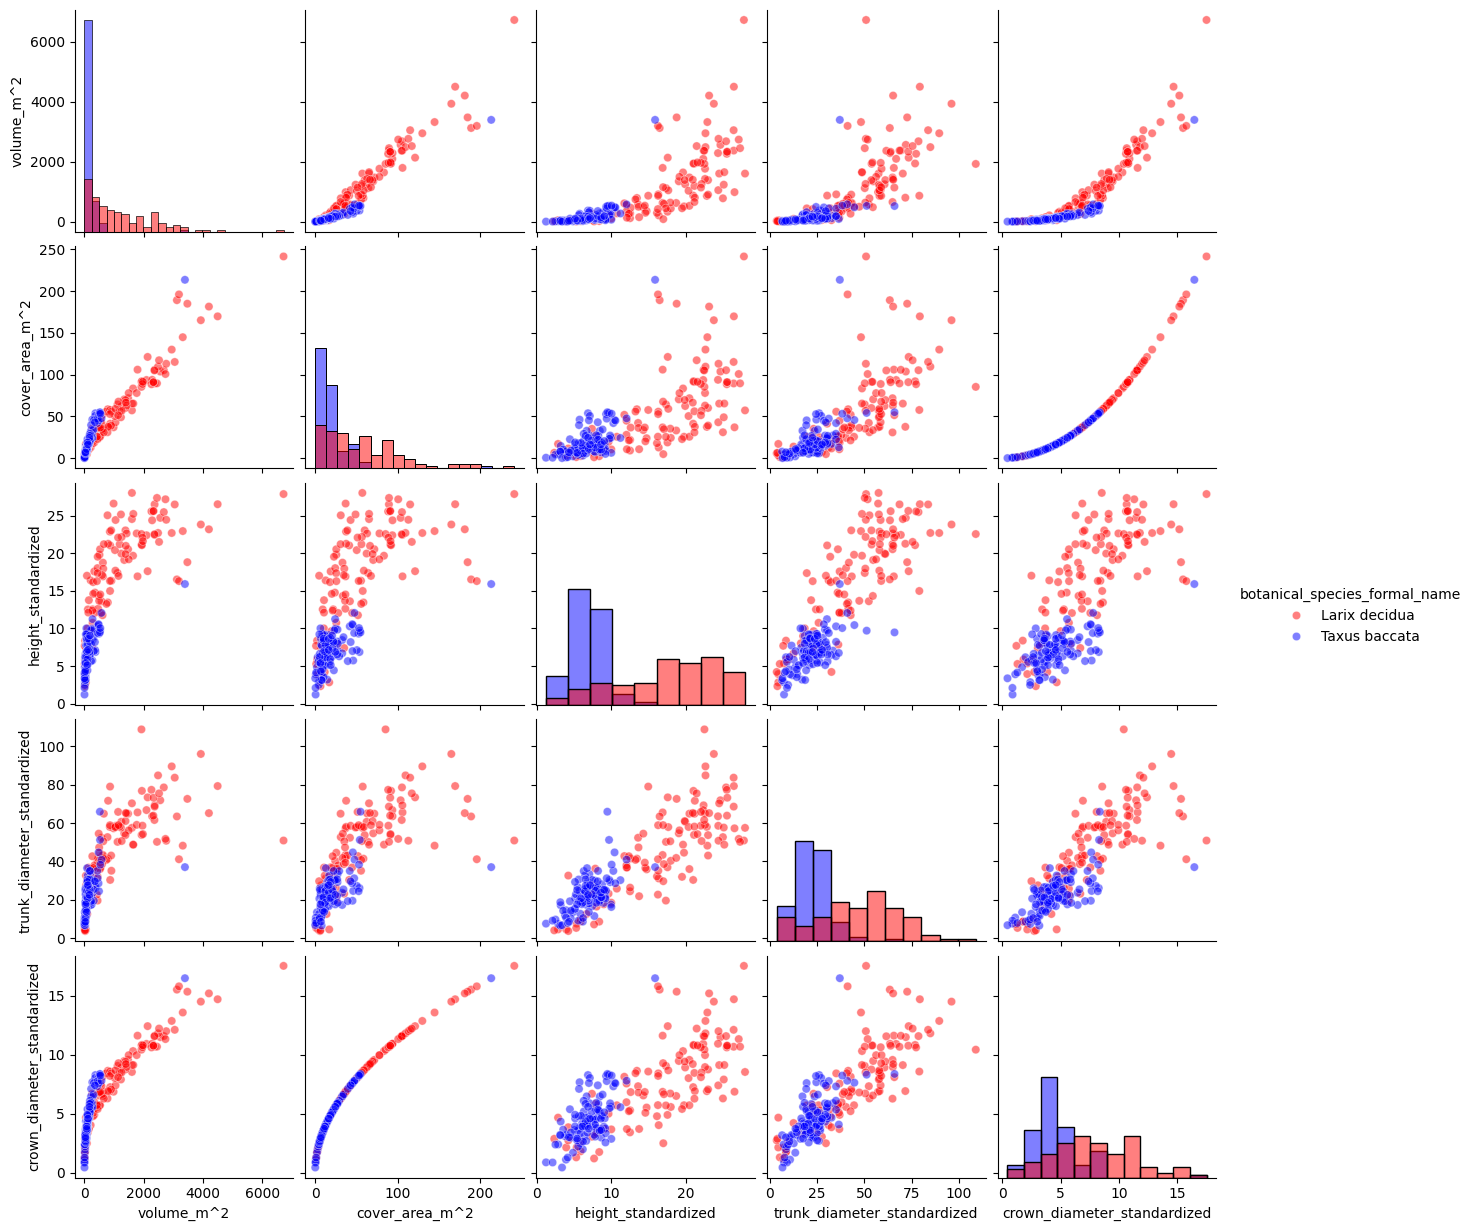

In [13]:
# matrix by species - comparison

## randomly select two valid species
rand_species_A = random.choice(valid_species)
rand_species_B = random.choice(valid_species)

# subset by species A
subset_A_with_labels = gdf.loc[(gdf['botanical_species_formal_name'] == rand_species_A) & 
                             (gdf['in_qualified_cohort']), 
                             ['botanical_species_formal_name', 'volume_m^2','cover_area_m^2','height_standardized', 
                              'trunk_diameter_standardized','crown_diameter_standardized']]

# subset by species B
subset_B_with_labels = gdf.loc[(gdf['botanical_species_formal_name'] == rand_species_B) & 
                             (gdf['in_qualified_cohort']), 
                             ['botanical_species_formal_name', 'volume_m^2','cover_area_m^2','height_standardized', 
                              'trunk_diameter_standardized','crown_diameter_standardized']]

# sample from each species 70% of the size of the smallest population
sizeA = subset_A_with_labels.shape[0]
sizeB = subset_B_with_labels.shape[0]
size = [sizeA if sizeA <= sizeB else sizeB]
size = round(size[0]*.7)
print(f'Sample size = {size}:')

# join subsets (Interesting that there is no gpd.concat. gpd relies on pd.conccat)
subset_with_labels = pd.concat([subset_A_with_labels.sample(size),subset_B_with_labels.sample(size)])

# pairplot
sns.pairplot(subset_with_labels, 
             hue='botanical_species_formal_name', 
             palette={rand_species_A: 'red', rand_species_B: 'blue'},
             diag_kind='hist', # Can also use 'kde' for smooth curves
             plot_kws={'alpha': 0.5})
